In [21]:
import numpy as np 
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/heartbeat-preprocessing-results/y.npy
/kaggle/input/heartbeat-preprocessing-results/X.npy


In [22]:
X = np.load('/kaggle/input/heartbeat-preprocessing-results/X.npy')
y = np.load('/kaggle/input/heartbeat-preprocessing-results/y.npy')

print(X.shape, y.shape)
print(np.unique(y))

(4884, 3380) (4884,)
[0 1]


In [23]:
print("Normal samples:", np.sum(y == 0))
print("Anomalies:", np.sum(y == 1))

Normal samples: 2969
Anomalies: 1915


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Train ONLY on normal samples
X_normal = X[y == 0]

X_train, X_val = train_test_split(
    X_normal, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Test set = full dataset
X_test = scaler.transform(X)
y_test = y

In [25]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(
    n_estimators=200,
    contamination=0.15,
    random_state=42
)

iso.fit(X_train)

scores_if = -iso.decision_function(X_test)

In [26]:
from sklearn.metrics import roc_auc_score, average_precision_score

auc_if = roc_auc_score(y_test, scores_if)
ap_if = average_precision_score(y_test, scores_if)

print(f"Isolation Forest ROC-AUC: {auc_if:.4f}")
print(f"Isolation Forest AP:      {ap_if:.4f}")

Isolation Forest ROC-AUC: 0.6858
Isolation Forest AP:      0.5886


In [27]:
from sklearn.svm import OneClassSVM

ocsvm = OneClassSVM(
    kernel='rbf',
    nu=0.05,
    gamma='scale'
)

ocsvm.fit(X_train)

scores_oc = -ocsvm.decision_function(X_test)

In [28]:
auc_oc = roc_auc_score(y_test, scores_oc)
ap_oc = average_precision_score(y_test, scores_oc)

print(f"OCSVM ROC-AUC: {auc_oc:.4f}")
print(f"OCSVM AP:      {ap_oc:.4f}")

OCSVM ROC-AUC: 0.6687
OCSVM AP:      0.6274


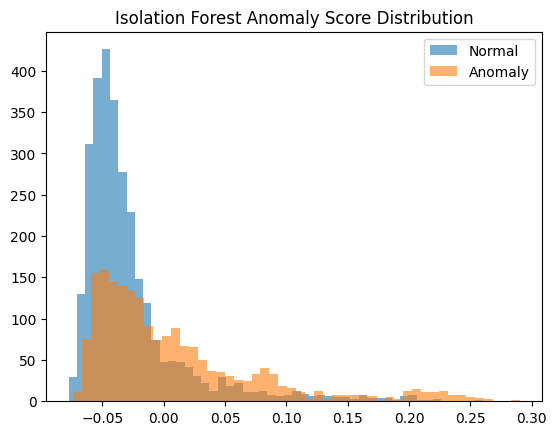

In [29]:
import matplotlib.pyplot as plt

plt.hist(scores_if[y_test == 0], bins=50, alpha=0.6, label='Normal')
plt.hist(scores_if[y_test == 1], bins=50, alpha=0.6, label='Anomaly')
plt.legend()
plt.title("Isolation Forest Anomaly Score Distribution")
plt.show()

In [30]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

In [31]:
input_dim = X_train.shape[1]   # 3380
latent_dim = 64

input_layer = layers.Input(shape=(input_dim,))

# Encoder
x = layers.Dense(1024, activation='relu')(input_layer)
x = layers.Dense(256, activation='relu')(x)
latent = layers.Dense(latent_dim, activation='relu', name='latent')(x)

# Decoder
x = layers.Dense(256, activation='relu')(latent)
x = layers.Dense(1024, activation='relu')(x)
output_layer = layers.Dense(input_dim, activation='linear')(x)

autoencoder = models.Model(inputs=input_layer, outputs=output_layer)
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 3380)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │     3,462,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3380)           │     3,464,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,485,300 (28.55 MB)

 Trainable params: 7,485,300 (28.55 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse'
)

early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = autoencoder.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0594 - val_loss: 0.0458
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0478 - val_loss: 0.0430
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0495 - val_loss: 0.0353
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0396 - val_loss: 0.0349
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0546 - val_loss: 0.0325
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0415 - val_loss: 0.0308
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0539 - val_loss: 0.0313
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0581 - val_loss: 0.0321
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0301 - val_loss: 0.0330
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0404 - val_loss: 0.0303
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0253 - val_loss: 0.0323
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step

In [33]:
X_test_recon = autoencoder.predict(X_test, batch_size=128)

recon_error = np.mean(
    np.square(X_test - X_test_recon),
    axis=1
)

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [34]:
auc_ae = roc_auc_score(y_test, recon_error)
ap_ae = average_precision_score(y_test, recon_error)

print(f"Autoencoder ROC-AUC: {auc_ae:.4f}")
print(f"Autoencoder AP:      {ap_ae:.4f}")

Autoencoder ROC-AUC: 0.7085
Autoencoder AP:      0.6106


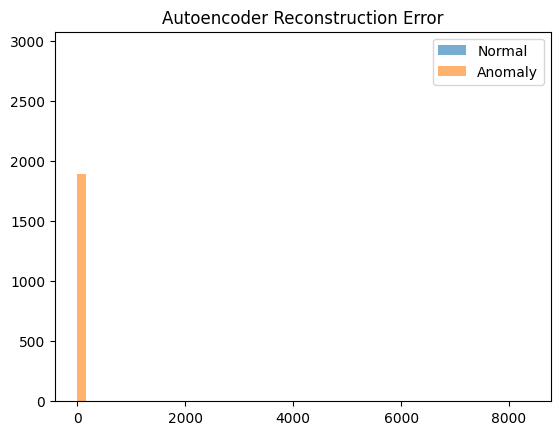

In [35]:
plt.hist(recon_error[y_test == 0], bins=50, alpha=0.6, label='Normal')
plt.hist(recon_error[y_test == 1], bins=50, alpha=0.6, label='Anomaly')
plt.legend()
plt.title("Autoencoder Reconstruction Error")
plt.show()

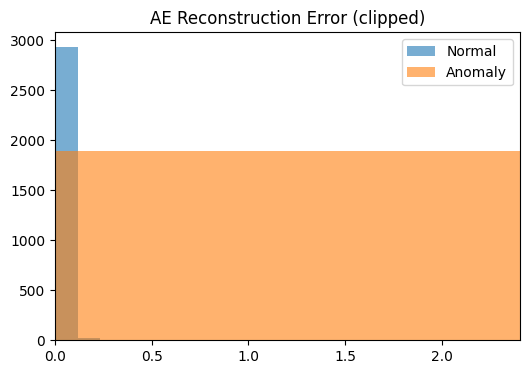

In [36]:
plt.figure(figsize=(6,4))
plt.hist(recon_error[y_test == 0], bins=50, alpha=0.6, label='Normal')
plt.hist(recon_error[y_test == 1], bins=50, alpha=0.6, label='Anomaly')
plt.xlim(0, np.percentile(recon_error, 99))  # clamp tail
plt.legend()
plt.title("AE Reconstruction Error (clipped)")
plt.show()


In [37]:
# Extract encoder
encoder = models.Model(
    inputs=autoencoder.input,
    outputs=autoencoder.get_layer("latent").output
)

Z_train = encoder.predict(X_train)
Z_test  = encoder.predict(X_test)

iso_latent = IsolationForest(
    n_estimators=200,
    contamination=0.15,
    random_state=42
)

iso_latent.fit(Z_train)

scores_hybrid = -iso_latent.decision_function(Z_test)

print("Hybrid ROC-AUC:", roc_auc_score(y_test, scores_hybrid))
print("Hybrid AP:", average_precision_score(y_test, scores_hybrid))

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Hybrid ROC-AUC: 0.6708135502894575
Hybrid AP: 0.5973486853510495


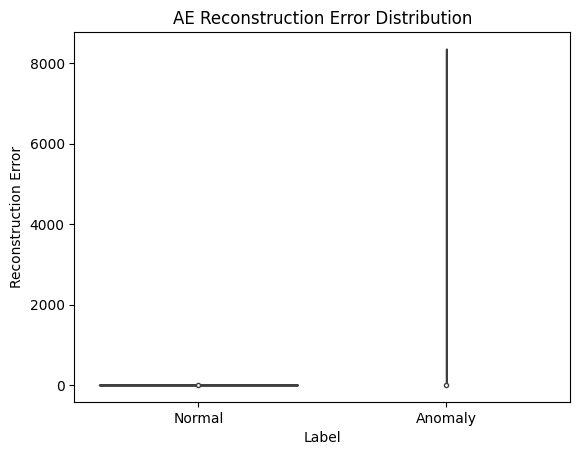

In [38]:
import seaborn as sns

df = pd.DataFrame({
    "Reconstruction Error": recon_error,
    "Label": y_test
})

sns.violinplot(x="Label", y="Reconstruction Error", data=df, cut=0)
plt.xticks([0,1], ["Normal", "Anomaly"])
plt.title("AE Reconstruction Error Distribution")
plt.show()